In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
# import ASRE models
cur_dir = os.getcwd()
ASREpy_dir = os.path.join(os.path.dirname(os.path.dirname(cur_dir)))
sys.path.append(ASREpy_dir)
import ASREpy.ground_deformation_models as gdm
import ASREpy
import pandas as pd
from scipy import interpolate
np.set_printoptions(threshold=np.inf)

In [2]:
def prepare_greenfield_disp(val_data_dir, vl, beam_id, beamX):
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)
    # Add the left half of Ux-GF and Uz-GF
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)

    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)
    return dispX_gf/1000, dispZ_gf/1000

def plot_verification(val_data_dir, vl, beam_id, beamX, model, axes, model_el = None,
                      beam_nodes_ind = None):
    
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)

    dispL_asre_file =  os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux.csv")
    dispL_asre_Franza = pd.read_csv(dispL_asre_file, header=None)

    dispV_asre_file =  os.path.join(val_data_dir, f'FranzaDeJong{beam_id}-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz.csv")
    dispV_asre_Franza = pd.read_csv(dispV_asre_file, header=None)

    # Sort the disp in file from left to right
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispL_asre_Franza.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispL_asre_Franza = pd.concat([left_half, dispL_asre_Franza])
    dispL_asre_Franza = dispL_asre_Franza.sort_values(by = 0).reset_index(drop = True)

    left_half = dispV_asre_Franza.copy()
    left_half[0] = -left_half[0]
    dispV_asre_Franza = pd.concat([left_half, dispV_asre_Franza])
    dispV_asre_Franza = dispV_asre_Franza.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)

    f = interpolate.interp1d(dispL_asre_Franza[0], dispL_asre_Franza[1], fill_value='extrapolate')
    dispL_asre_Franza = f(beamX)

    f = interpolate.interp1d(dispV_asre_Franza[0], dispV_asre_Franza[1], fill_value='extrapolate')
    dispV_asre_Franza = f(beamX)
    
    axes[0].plot(beamX, dispX_gf, 'r:', label = 'experiment')
    axes[1].plot(beamX, dispZ_gf, 'r:', label = 'experiment')

    axes[0].plot(beamX, dispL_asre_Franza, 'b', label = 'ASRE_Franza')
    axes[1].plot(beamX, dispV_asre_Franza, 'b', label = 'ASRE_Franza')
    
    if getattr(model, 'footing_nodes_ind', None) is not None:
        if model_el is not None:
            axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')
            axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')

            axes[0].plot(beamX, model_el.beam_DispL[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
            axes[1].plot(beamX, model_el.beam_DispV[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
        else:
            axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')
            axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')
    else:
        if model_el is not None:
            axes[0].plot(beamX, model.beam_DispL*1000, 'bx', label = 'ASREpy_ep')
            axes[1].plot(beamX, model.beam_DispV*1000, 'bx', label = 'ASREpy_ep')

            axes[0].plot(beamX, model_el.beam_DispL*1000, 'b^', label = 'ASREpy_el')
            axes[1].plot(beamX, model_el.beam_DispV*1000, 'b^', label = 'ASREpy_el')
        else:
            axes[0].plot(beamX, model.beam_DispL*1000, 'bx', label = 'ASREpy')
            axes[1].plot(beamX, model.beam_DispV*1000, 'bx', label = 'ASREpy')

    axes[0].legend()
    axes[1].legend()

    axes[0].set_title(f'{beam_id}, Ux')
    axes[1].set_title(f'{beam_id}, Uz')

    axes[0].set_xlim([0, 15])
    axes[1].set_xlim([0, 15])
    axes[0].set_ylim([-60, 36])
    axes[1].set_ylim([-60, 36])

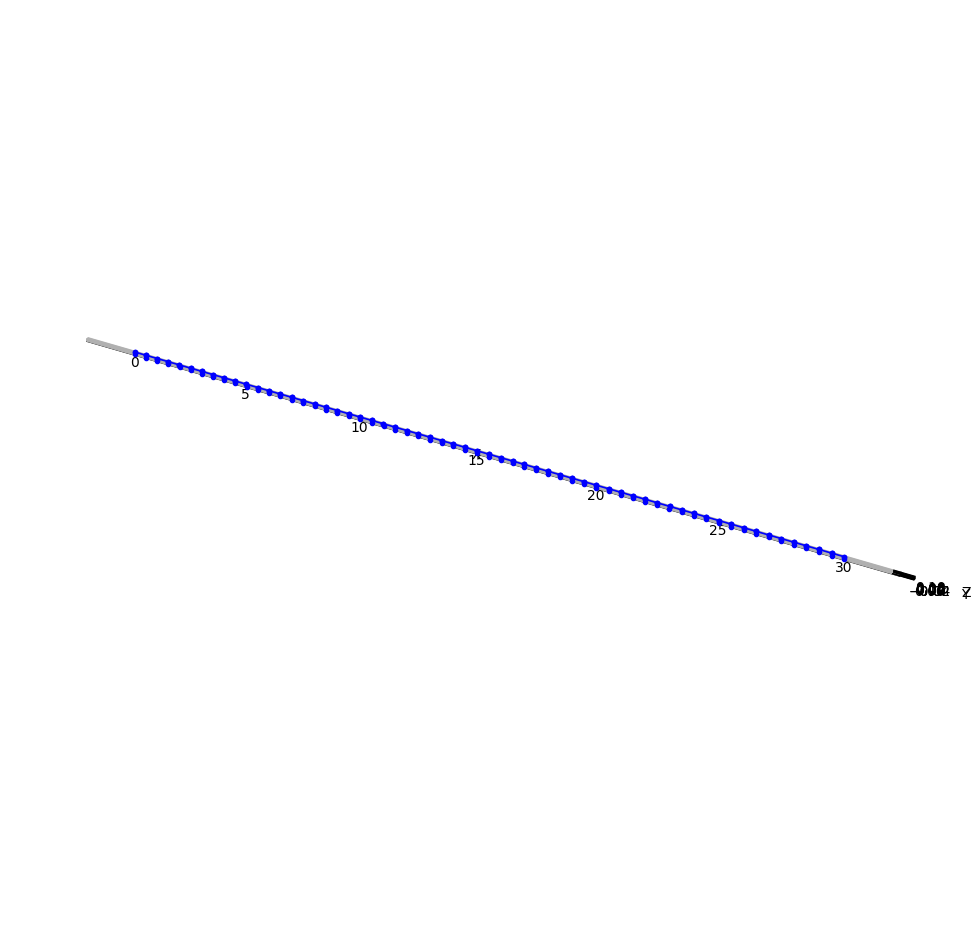

In [3]:
## Create a frame model that is equivalent to STR-1
beam_to_node = {}
# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n_bay = 60        # Number of bays
l_bay = 0.5      # Length of each bay
h_bay = 0.1      # Height of each story
numStories = 1  # Number of stories

# Material properties frame
b_frame = 10
d_beam = 0.12
d_column = 0.12
E = 70e9  # Young's Modulus in Pa
E_column = E * 10000
A_beam = b_frame * d_beam   # Area of the element in m^2
A_column = b_frame * d_column
mu = 0.28
G = E/(2*(1+mu))
G_column = E_column/(2*(1+mu))
Iy_beam = b_frame * d_beam**3/12
Iz_beam = d_beam**3 * b_frame/12  # Moment of Inertia in m^4
Iy_column = b_frame * d_column**3/12
Iz_column = d_column**3 * b_frame/12  # Moment of Inertia in m^4

# calculate torsional constant for beam
a = max(b_frame, d_beam)
b = min(b_frame, d_beam)
J_beam = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))
# calculate torsional constant for column
a = max(b_frame, d_column)
b = min(b_frame, d_column)
J_column = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Define footing meshing parameters
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories

footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []

beam_nodes_ind = []
beam_nodes_coord_x = []

# Create nodes
for i in range(numStories + 1):
    for j in range(n_bay + 1):
        nodeTag = i * (n_bay + 1) + j + 0
        x = j * l_bay
        z = i * h_bay
        ops.node(nodeTag, x, 0, z)
        if i == 0:
            footing_nodes_ind.append(nodeTag)
            footing_coord_x.append(x)
            footing_coord_y.append(0)
            footing_coord_z.append(z)
        if i == 1:
            beam_nodes_ind.append(nodeTag)
            beam_nodes_coord_x.append(x)
beam_nodes_ind = np.array(beam_nodes_ind).astype(int)
beam_nodes_coord_x = np.array(beam_nodes_coord_x).astype(float)
# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
# Define elements
for i in range(numStories):
    for j in range(n_bay):
        # Horizontal elements (beams)
        nodeI = (i + 1) * (n_bay + 1) + j + 0
        nodeJ = nodeI + 1
        eleTag = i * (n_bay) + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_beam, E, G, J_beam, Iy_beam, Iz_beam, horizontal_gTTag)
        beam_to_node[eleTag] = {'nodes':[nodeI, nodeJ],
                                'length': l_bay}

    for j in range(n_bay + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n_bay + 1) + j + 0
            nodeJ = nodeI + (n_bay + 1)
            eleTag = n_bay * numStories + i * (n_bay + 1) + j + 0
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_column, E_column, G_column, J_column, Iy_column, Iz_column, vertical_gTTag)


footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# Calculate the self weight loads (simplified as point loads, needs refinement)
num_of_nodes = num_nodes_in_frame + len(footing_nodes_ind) - (n_bay + 1)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)
for _, nodes in beam_to_node.items():
    nodeI = nodes['nodes'][0]
    nodeJ = nodes['nodes'][1]
    length = nodes['length']
    self_weight_unit[nodeI * 6 + 2] += (-1/2*length)
    self_weight_unit[nodeJ * 6 + 2] += (-1/2*length)

# Define the time series
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Define the constraint method
ops.constraints("Plain")

opsv.plot_model(element_labels=0, fig_wi_he = (50,30), local_axes=0,
                node_labels=0);

In [4]:
val_data_dir = r"VerificationData"

In [5]:
footing_coord_x = footing_coord_x - 15 

In [15]:
beam_id = "STR-1"
z0 = 11.25
vl = 2.0/100
k = 0.55


dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, beam_id, footing_coord_x)

[ 0.00042353  0.0004298   0.00045047  0.00055996  0.00066946  0.00077895
  0.00100053  0.00133777  0.0017107   0.00209336  0.00271875  0.00347457
  0.00463202  0.00565388  0.00659813  0.00742684  0.00825177  0.00886504
  0.00956666  0.0104504   0.01127843  0.01128471  0.01119484  0.01082601
  0.00989182  0.00863999  0.00739029  0.00605747  0.00369511  0.00184313
  0.         -0.00184313 -0.00369511 -0.00605747 -0.00739029 -0.00863999
 -0.00989182 -0.01082601 -0.01119484 -0.01128471 -0.01127843 -0.0104504
 -0.00956666 -0.00886504 -0.00825177 -0.00742684 -0.00659813 -0.00565388
 -0.00463202 -0.00347457 -0.00271875 -0.00209336 -0.0017107  -0.00133777
 -0.00100053 -0.00077895 -0.00066946 -0.00055996 -0.00045047 -0.0004298
 -0.00042353] dispX_gf [-0.003377   -0.00348106 -0.00363683 -0.00386386 -0.00421637 -0.00459724
 -0.00521789 -0.00583855 -0.00625315 -0.00667817 -0.00735392 -0.00805718
 -0.00901207 -0.01000046 -0.01101475 -0.01200239 -0.01308132 -0.01431836
 -0.01592797 -0.01770563 -0.01

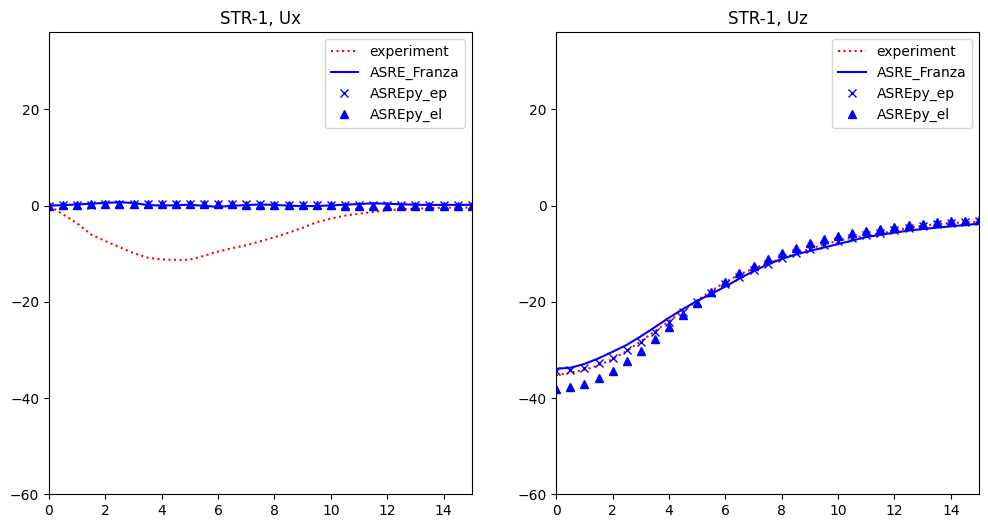

In [7]:
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
qz = 3.2*10*1000 * self_weight_unit
ele_length = footing_coord_x[1] - footing_coord_x[0]
ele_width = b_frame
footing_ele_length = ele_length * np.ones_like(footing_nodes_ind).astype(float)
footing_ele_width = ele_width * np.ones_like(footing_nodes_ind).astype(float)

model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, vl, beam_id, footing_coord_x, model, axes, model_el)

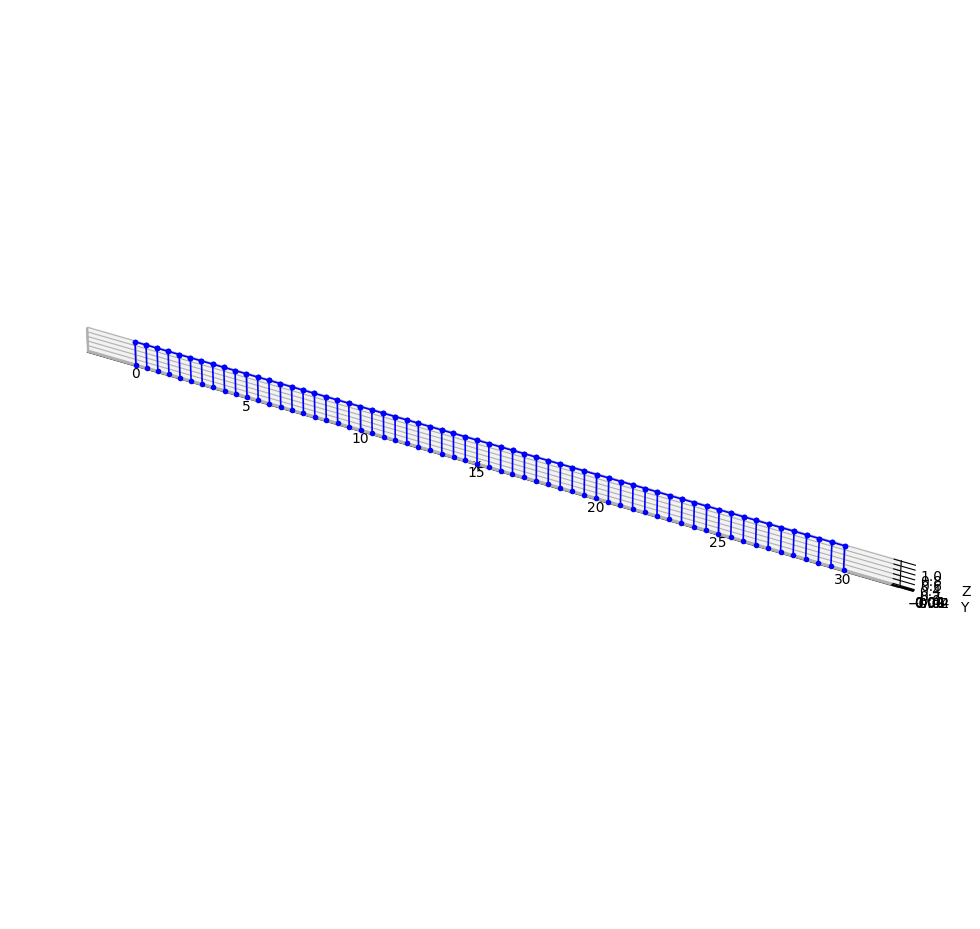

In [8]:
## Create a frame model that is equivalent to STR-1 but has 1 m offset from ground
beam_to_node = {}
# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n_bay = 60        # Number of bays
l_bay = 0.5      # Length of each bay
# h_bay_1 = 0.1      # Height of each story
# h_bay_2 = 1.0      # Height of each story
# numStories = 2  # Number of stories

h_bay_1 = 1.0      # Height of each story
h_bay_2 = 1.0      # Height of each story
numStories = 1  # Number of stories

# Material properties frame
b_frame = 10
d_beam = 0.12
d_column = 0.12*100
E = 70e9  # Young's Modulus in Pa
E_column = E * 10000
A_beam = b_frame * d_beam   # Area of the element in m^2
A_column = b_frame * d_column
mu = 0.28
G = E/(2*(1+mu))
G_column = E_column/(2*(1+mu))
Iy_beam = b_frame * d_beam**3/12
Iz_beam = d_beam**3 * b_frame/12  # Moment of Inertia in m^4
Iy_column = b_frame * d_column**3/12
Iz_column = d_column**3 * b_frame/12  # Moment of Inertia in m^4

# calculate torsional constant for beam
a = max(b_frame, d_beam)
b = min(b_frame, d_beam)
J_beam = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))
# calculate torsional constant for column
a = max(b_frame, d_column)
b = min(b_frame, d_column)
J_column = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Define footing meshing parameters
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories

footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []

beam_nodes_ind = []
beam_coord_x = []

# Create nodes
for i in range(numStories + 1):
    for j in range(n_bay + 1):
        nodeTag = i * (n_bay + 1) + j + 0
        x = j * l_bay
        if i == 0:
            z = 0
        if i == 1:
            z = h_bay_1
        if i == 2:
            z = h_bay_1 + h_bay_2
        ops.node(nodeTag, x, 0, z)
        if i == 0:
            footing_nodes_ind.append(nodeTag)
            footing_coord_x.append(x)
            footing_coord_y.append(0)
            footing_coord_z.append(z)
        if i == 1:
            beam_nodes_ind.append(nodeTag)
            beam_coord_x.append(x)
beam_nodes_ind = np.array(beam_nodes_ind).astype(int)
beam_coord_x = np.array(beam_coord_x).astype(float)

# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
# Define elements
for i in range(numStories):
    for j in range(n_bay):
        # Horizontal elements (beams)
        nodeI = (i + 1) * (n_bay + 1) + j + 0
        nodeJ = nodeI + 1
        eleTag = i * (n_bay) + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_beam, E, G, J_beam, Iy_beam, Iz_beam, horizontal_gTTag)
        beam_to_node[eleTag] = {'nodes':[nodeI, nodeJ],
                                'length': l_bay}

    for j in range(n_bay + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n_bay + 1) + j + 0
            nodeJ = nodeI + (n_bay + 1)
            eleTag = n_bay * numStories + i * (n_bay + 1) + j + 0
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_column, E_column, G_column, J_column, Iy_column, Iz_column, vertical_gTTag)


footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# Calculate the self weight loads (simplified as point loads, needs refinement)
num_of_nodes = num_nodes_in_frame + len(footing_nodes_ind) - (n_bay + 1)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)
for _, nodes in beam_to_node.items():
    nodeI = nodes['nodes'][0]
    nodeJ = nodes['nodes'][1]
    length = nodes['length']
    self_weight_unit[nodeI * 6 + 2] += (-1/2*length)
    self_weight_unit[nodeJ * 6 + 2] += (-1/2*length)

# Define the time series
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Define the constraint method
ops.constraints("Plain")

opsv.plot_model(element_labels=0, fig_wi_he = (50,30), local_axes=0,
                node_labels=0);

In [9]:
footing_coord_x = footing_coord_x - 15 
beam_coord_x = beam_coord_x - 15

In [10]:
beam_id = "STR-1"
z0 = 11.25
vl = 2.0/100
k = 0.55


dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, beam_id, footing_coord_x)
dispX_gf = dispX_gf * 0.0 # if no horiztonal displacement for testing

In [11]:
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
qz = 3.2*10*1000 * self_weight_unit
ele_length = footing_coord_x[1] - footing_coord_x[0]
ele_width = b_frame
footing_ele_length = ele_length * np.ones_like(footing_nodes_ind).astype(float)
footing_ele_width = ele_width * np.ones_like(footing_nodes_ind).astype(float)

model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')


True

In [12]:
# STR-1, equivalent beam model with d_NA = 1 m
beam_id = "STR-1"
beamX = np.linspace(-15, 15, 61)
z0 = 11.25
vl = 2.0/100
k = 0.55

dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, beam_id, beamX)
dispX_gf = dispX_gf * 0.0 # if no horiztonal displacement for testing
dfoot = 0.12
bfoot = 10
beamY = np.zeros_like(beamX)
beamZ = np.zeros_like(beamX)
Eb = 70e9
EoverG = 0.001 # Assume very large G to model the Euler–Bernoulli beam used in Franza and DeJong
qfoot = 3.2*10*1000
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
d_na = 1
beam_model = ASREpy.ASRE_Timoshenko_model(beamX.size, beamX, beamY,
                                     beamZ, dfoot, bfoot)
beam_model.set_beam_properties(Eb, EoverG, qfoot, d_NA=d_na)
beam_model.set_soil_properties(Es, nis, mu_int)

beam_model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')

beam_model_el = ASREpy.ASRE_Timoshenko_model(beamX.size, beamX, beamY,
                                     beamZ, dfoot, bfoot,
                                     solver='elastic')
beam_model_el.set_beam_properties(Eb, EoverG, qfoot, d_NA=d_na)
beam_model_el.set_soil_properties(Es, nis, mu_int)

beam_model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')

True

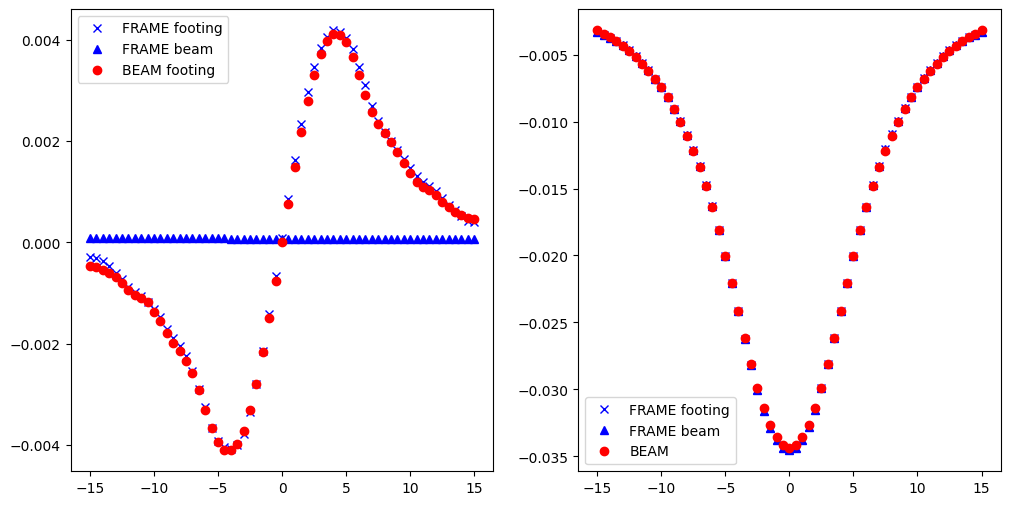

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
# axes[0].plot(beam_coord_x, model.result_array_ptr[beam_nodes_ind * 6 + 0], 'bx', label = 'FRAME')
axes[0].plot(footing_coord_x, model.result_array_ptr[footing_nodes_ind * 6 + 0], 'bx', label = 'FRAME footing')
axes[0].plot(beam_coord_x, model.result_array_ptr[beam_nodes_ind * 6 + 0], 'b^', label = 'FRAME beam')
axes[0].plot(beamX, beam_model.beam_DispL, 'ro', label = 'BEAM footing')
axes[1].plot(footing_coord_x, model.result_array_ptr[footing_nodes_ind * 6 + 2], 'bx', label = 'FRAME footing')
axes[1].plot(beam_coord_x, model.result_array_ptr[beam_nodes_ind * 6 + 2], 'b^', label = 'FRAME beam')
axes[1].plot(beamX, beam_model.beam_DispV, 'ro', label = 'BEAM')
axes[0].legend()
axes[1].legend()

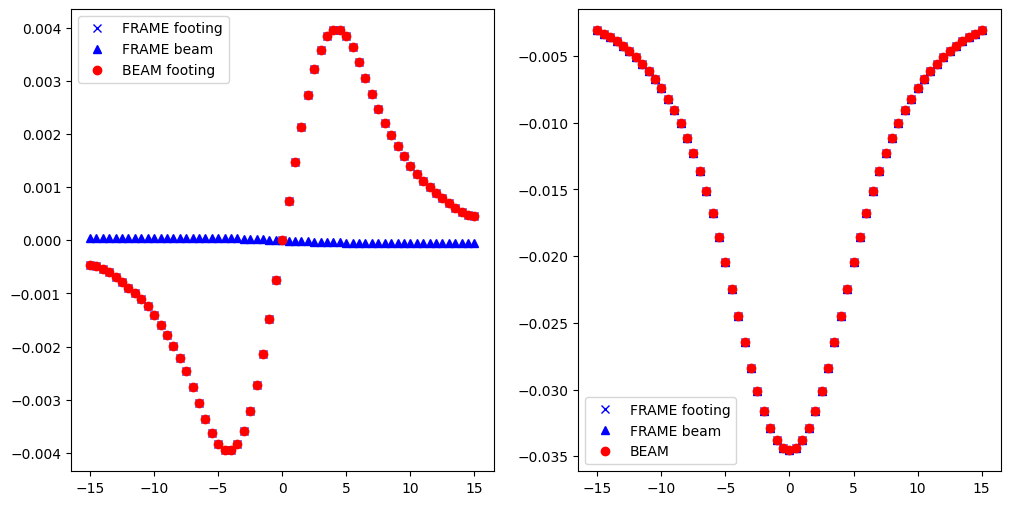

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
# axes[0].plot(beam_coord_x, model.result_array_ptr[beam_nodes_ind * 6 + 0], 'bx', label = 'FRAME')
axes[0].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind * 6 + 0], 'bx', label = 'FRAME footing')
axes[0].plot(beam_coord_x, model_el.result_array_ptr[beam_nodes_ind * 6 + 0], 'b^', label = 'FRAME beam')
axes[0].plot(beamX, beam_model_el.beam_DispL, 'ro', label = 'BEAM footing')
axes[1].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind * 6 + 2], 'bx', label = 'FRAME footing')
axes[1].plot(beam_coord_x, model_el.result_array_ptr[beam_nodes_ind * 6 + 2], 'b^', label = 'FRAME beam')
axes[1].plot(beamX, beam_model_el.beam_DispV, 'ro', label = 'BEAM')
axes[0].legend()
axes[1].legend()